In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2

IMG_SIZE = 128
BASE_DIR = '/content/drive/MyDrive/CattleImageRepository'

def load_and_preprocess_data(base_dir, subdirs):
    X, y = [], []

    x_dirs = ['X', 'x1_files', 'x2_files', 'x3_files', 'x4_files', 'X']
    y_dirs = ['Y', 'y1_files', 'y2_files', 'y3_files', 'y4_files', 'y']

    for subdir in subdirs:

        counter = 0

        full_path = os.path.join(base_dir, *subdir.split('/'))

        x_dir, y_dir = None, None

        for x_subdir, y_subdir in zip(x_dirs, y_dirs):
            test_x_dir = os.path.join(full_path, x_subdir)
            test_y_dir = os.path.join(full_path, y_subdir)
            if os.path.isdir(test_x_dir) and os.path.isdir(test_y_dir):
                x_dir, y_dir = test_x_dir, test_y_dir
                break

        if x_dir and y_dir:
            x_files = [f for f in os.listdir(x_dir) if f.endswith(('x.png', 'x1.png', 'x.jpeg', 'x1.jpeg'))]

            for x_file in x_files:
                y_file = x_file.replace('x.', 'y.').replace('x1.', 'y1.')
                y_path = os.path.join(y_dir, y_file)
                if os.path.exists(y_path):
                    x_path = os.path.join(x_dir, x_file)
                    img = cv2.imread(x_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    X.append(img)

                    mask = cv2.imread(y_path)
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                    y.append(mask)

                    counter += 1

            print(f"{subdir}: {counter} imagens processadas.")
        else:
            print(f"Erro: Pastas 'X' ou 'Y/y' não encontradas em {subdir}")

    return np.array(X), np.array(y)

subdirs = [
    'G1/01-08-2024', 'G1/08-08-2024',
    'G2/29-07/00000000196000500', 'G2/29-07/00000000196000400',
    'G2/06-08/Video_1', 'G2/06-08/Video_2',
    'G3/30-07/termica', 'G4/02-08'
]

X, y = load_and_preprocess_data(BASE_DIR, subdirs)
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

G1/01-08-2024: 580 imagens processadas.
G1/08-08-2024: 137 imagens processadas.
G2/29-07/00000000196000500: 218 imagens processadas.
G2/29-07/00000000196000400: 268 imagens processadas.
G2/06-08/Video_1: 771 imagens processadas.
G2/06-08/Video_2: 63 imagens processadas.
G3/30-07/termica: 607 imagens processadas.
G4/02-08: 830 imagens processadas.


(128, 128, 3)


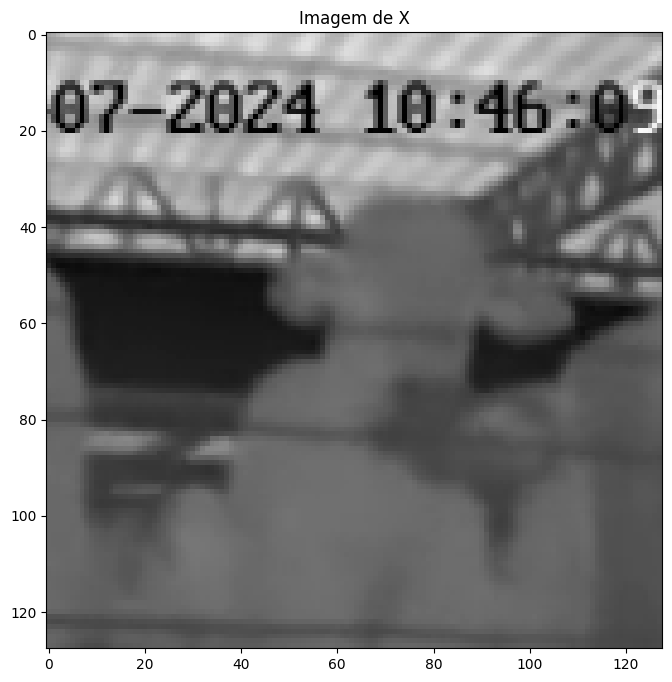

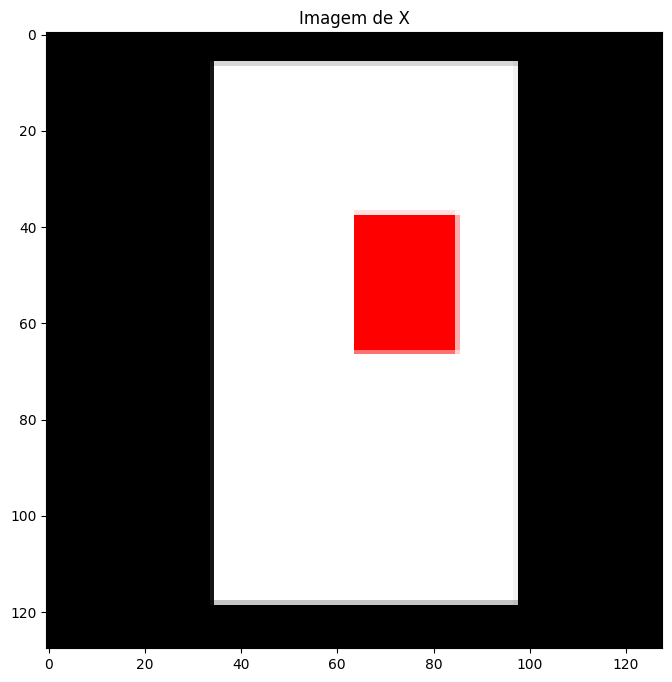

In [ ]:
import matplotlib.pyplot as plt

image = X[np.random.randint(0, X.shape[0])]
image2= y[np.random.randint(0, y.shape[0])]

if image.shape[-1] == 1:
    image = image.squeeze()

if image2.shape[-1] == 1:
    image2 = image2.squeeze()

print(image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Imagem de X')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Imagem de X')
plt.show()

In [ ]:
X.shape, y.shape

((3474, 128, 128, 3, 1), (3474, 128, 128, 3, 1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [ ]:
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (2779, 128, 128, 3, 1)
Shape de X_test: (695, 128, 128, 3, 1)
Shape de y_train: (2779, 128, 128, 3, 1)
Shape de y_test: (695, 128, 128, 3, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

def apply_data_augmentation(X, y, variations=2):

    X_augmented = []
    y_augmented = []

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    for i in range(X.shape[0]):

        image = X[i]
        mask = y[i]

        if image.ndim == 4:
            image = image.squeeze()
        if mask.ndim == 4:
            mask = mask.squeeze()

        X_augmented.append(image)
        y_augmented.append(mask)

        for j in range(variations):
            params = datagen.get_random_transform(image.shape)

            augmented_image = datagen.apply_transform(image, params)
            augmented_mask = datagen.apply_transform(mask, params)

            X_augmented.append(augmented_image)
            y_augmented.append(augmented_mask)

    return np.array(X_augmented), np.array(y_augmented)

X_train_augmented, y_train_augmented = apply_data_augmentation(X_train, y_train)

In [ ]:
X_train_augmented = X_train_augmented / 255.0
y_train_augmented = y_train_augmented / 255.0

X_test = X_test / 255.0
y_test = y_test / 255.0

In [ ]:
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [ ]:
X_train_augmented.shape, y_train_augmented.shape

((8337, 128, 128, 3), (8337, 128, 128, 3))

In [ ]:
X_test.shape, y_test.shape

((695, 128, 128, 3), (695, 128, 128, 3))

(-0.5, 127.5, 127.5, -0.5)

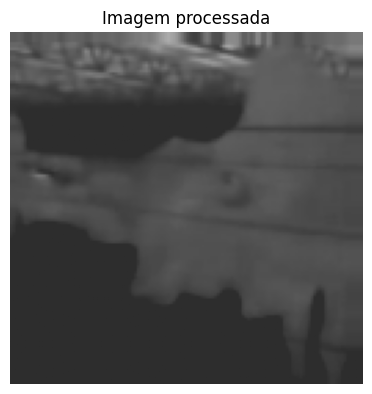

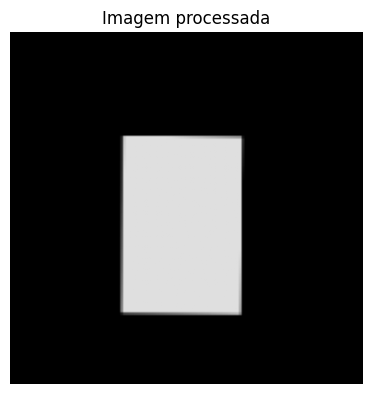

In [ ]:
index = np.random.randint(0, X_train_augmented.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

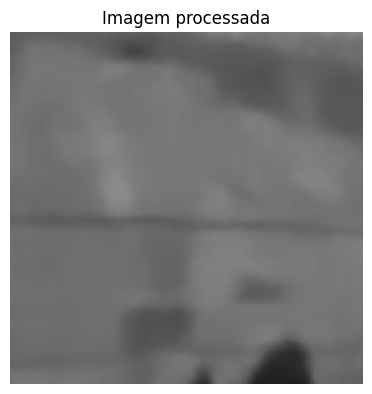

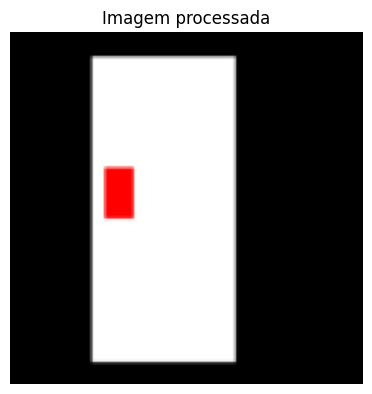

In [ ]:
index = np.random.randint(0, X_test.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_test[index])
plt.title("Imagem processada")
plt.axis('off')

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

def reduce_colors(img_array, colors):
    assert img_array.shape == (128, 128, 3), "Input array must have shape (128, 128, 3)"
    fixed_colors = np.array(colors)
    pixels = img_array.reshape(-1, 3)
    distances = np.sqrt(((pixels[:, np.newaxis, :] - fixed_colors) ** 2).sum(axis=2))
    nearest_color_indices = distances.argmin(axis=1)
    new_img = fixed_colors[nearest_color_indices].reshape(img_array.shape)
    return (new_img * 255).astype('uint8')

def reduce_colors_dataset(dataset, colors):
    return np.array([reduce_colors(img, colors) for img in tqdm(dataset, desc="Processing images")])

In [ ]:
colors = [
    (1.0, 1.0, 1.0),  # White
    (1.0, 0.0, 0.0),  # Red
    (0.0, 0.0, 0.0)   # Black
]

y_train_reduced = reduce_colors_dataset(y_train_augmented, colors)
y_test_reduced = reduce_colors_dataset(y_test, colors)

Processing images: 100%|██████████| 695/695 [00:01<00:00, 400.73it/s]


In [ ]:
X_train_augmented.shape

(8337, 128, 128, 3)

In [ ]:
y_train_reduced.shape

(8337, 128, 128, 3)

In [ ]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
def process_images(X_train, X_test):

    def apply_clahe(image):
        image_gray = (image * 255).astype(np.uint8)
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(2, 2))
        image_clahe = clahe.apply(image_gray)
        image_clahe_rgb = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        return image_clahe_rgb / 255.0

    def adjust_contrast(image, factor):
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        enhancer = ImageEnhance.Contrast(image_pil)
        image_pil = enhancer.enhance(factor)
        return np.array(image_pil) / 255.0

    def process_single_image(image):
        clahe_image = apply_clahe(image)
        adjusted_image = adjust_contrast(clahe_image, 1.5)
        return adjusted_image

    X_train_processed = np.array([process_single_image(img) for img in X_train])
    X_test_processed = np.array([process_single_image(img) for img in X_test])

    return X_train_processed, X_test_processed

In [ ]:
X_train_processed, X_test_processed = process_images(X_train_augmented.copy(), X_test.copy())

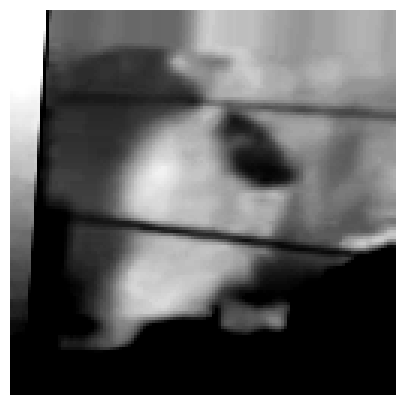

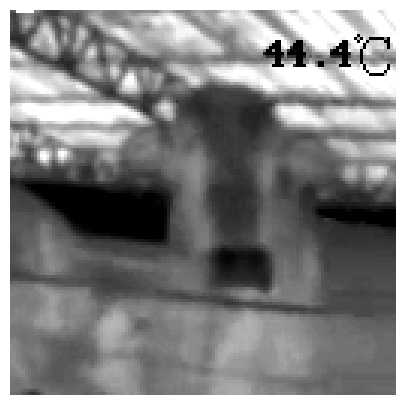

In [ ]:
index_random = np.random.randint(0, X_test_processed.shape[0])

plt.figure(figsize=(10, 5))
plt.imshow(X_train_processed[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

plt.figure(figsize=(10, 5))
plt.imshow(X_test_processed[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

In [ ]:
X_train, y_train = X_train_processed, y_train_reduced
X_test, y_test = X_test_processed, y_test_reduced

In [ ]:
val_split = 0.2
val_samples = int(len(X_train) * val_split)
X_train_vgg16, y_train_vgg16 = X_train[:-val_samples], y_train[:-val_samples]
X_val_vgg16, y_val_vgg16 = X_train[-val_samples:], y_train[-val_samples:]

In [ ]:
import numpy as np
import tensorflow as tf

def preprocess_y(y):
    # Definir as cores para cada classe
    black = [0, 0, 0]
    white = [255, 255, 255]
    red = [255, 0, 0]

    # Criar uma máscara para cada classe
    mask_black = np.all(y == black, axis=-1)
    mask_white = np.all(y == white, axis=-1)
    mask_red = np.all(y == red, axis=-1)

    # Empilhar as máscaras para criar um tensor de 3 canais
    y_processed = np.stack([mask_black, mask_white, mask_red], axis=-1).astype(np.float32)

    return y_processed

# Aplicar o pré-processamento aos dados de treino e validação
y_train_processed = preprocess_y(y_train_vgg16)
y_val_processed = preprocess_y(y_val_vgg16)

# Verificar as formas dos arrays processados
print("Forma de y_train_processed:", y_train_processed.shape)
print("Forma de y_val_processed:", y_val_processed.shape)

# Verificar se as máscaras são mutuamente exclusivas
assert np.allclose(np.sum(y_train_processed, axis=-1), 1.0)
assert np.allclose(np.sum(y_val_processed, axis=-1), 1.0)

# Se você estiver usando TensorFlow/Keras, pode ser útil converter para tensores TensorFlow
y_train_processed = tf.convert_to_tensor(y_train_processed)
y_val_processed = tf.convert_to_tensor(y_val_processed)

Forma de y_train_processed: (6670, 128, 128, 3)
Forma de y_val_processed: (1667, 128, 128, 3)


In [ ]:
y_test_processed = preprocess_y(y_test)
y_test_processed = tf.convert_to_tensor(y_test_processed)

In [ ]:
y_train_processed.shape

TensorShape([6670, 128, 128, 3])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras import backend as K

tf.random.set_seed(56)

vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

output_ = vgg16_base.output

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']:
        layer.trainable = False

vgg_model = Model(inputs=vgg16_base.input, outputs=output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

vgg_model.summary()

K.clear_session()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU

def three_class_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculando os pesos das classes
        class_weights = 1.0 / (K.sum(K.sum(y_true, axis=[1, 2]), axis=0) + epsilon)
        class_weights = class_weights / K.sum(class_weights)
        class_weights = K.expand_dims(K.expand_dims(K.expand_dims(class_weights, axis=0), axis=0), axis=0)

        # Focal loss
        ce_loss = categorical_crossentropy(y_true, y_pred)
        pt = K.sum(y_true * y_pred, axis=-1)
        focal_loss = alpha * K.pow(1. - pt, gamma) * ce_loss

        # Aplicando os pesos das classes
        weighted_focal_loss = K.sum(class_weights * y_true, axis=-1) * focal_loss

        return K.mean(weighted_focal_loss)
    return loss

def ModelEnhancer():
    input_shape = (128, 128, 3)
    VGG16_weight = vgg_model.get_weights()
    vgg_base = VGG16(include_top=False, weights=None, input_shape=input_shape)
    vgg_base.set_weights(VGG16_weight)
    last_layer = vgg_base.output

    set_trainable = False
    for layer in vgg_base.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']:
            layer.trainable = False

    # Upsampling path
    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    # Ensure shapes match before concatenation
    block5_output = vgg_base.get_layer("block5_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block5_output)[1:3]:
        block5_output = Cropping2D(cropping=((1, 1), (1, 1)))(block5_output)
    concat_1 = concatenate([model_, block5_output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    # Ensure shapes match before concatenation
    block4_output = vgg_base.get_layer("block4_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block4_output)[1:3]:
        block4_output = Cropping2D(cropping=((1, 1), (1, 1)))(block4_output)
    concat_2 = concatenate([model_, block4_output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    # Ensure shapes match before concatenation
    block3_output = vgg_base.get_layer("block3_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block3_output)[1:3]:
        block3_output = Cropping2D(cropping=((1, 1), (1, 1)))(block3_output)
    concat_3 = concatenate([model_, block3_output])

    model_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    # Ensure shapes match before concatenation
    block2_output = vgg_base.get_layer("block2_conv2").output
    if K.int_shape(model_)[1:3] != K.int_shape(block2_output)[1:3]:
        block2_output = Cropping2D(cropping=((1, 1), (1, 1)))(block2_output)
    concat_4 = concatenate([model_, block2_output])

    model_ = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    # Ensure shapes match before concatenation
    block1_output = vgg_base.get_layer("block1_conv2").output
    if K.int_shape(model_)[1:3] != K.int_shape(block1_output)[1:3]:
        block1_output = Cropping2D(cropping=((1, 1), (1, 1)))(block1_output)
    concat_5 = concatenate([model_, block1_output])

    model_ = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (3, 3), strides=(1, 1), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (1, 1), activation='softmax', padding='same')(model_)

    model_ = Model(vgg_base.input, model_)

    return model_

model = ModelEnhancer()
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=three_class_focal_loss(),
              metrics=[CategoricalAccuracy(), MeanIoU(num_classes=3)])

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_three_class_model.keras', save_best_only=True, monitor='val_mean_io_u')

# Treinamento
history = model.fit(
    X_train_vgg16, y_train_processed,
    validation_data=(X_val_vgg16, y_val_processed),
    epochs=6,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    batch_size=32
)

Epoch 1/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - categorical_accuracy: 0.5017 - loss: 0.0035 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.7747 - val_loss: 0.0021 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - categorical_accuracy: 0.7894 - loss: 0.0020 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.7969 - val_loss: 0.0017 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 3/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - categorical_accuracy: 0.8320 - loss: 0.0016 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.8454 - val_loss: 0.0016 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 4/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - categorical_accuracy: 0.8528 - loss: 0.0013 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.8478 - val_loss: 0.0014 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 5/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - categorical_accuracy: 0.8676

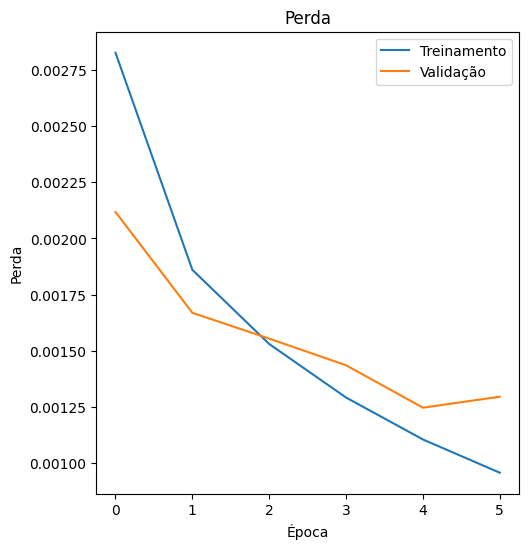

In [ ]:
import matplotlib.pyplot as plt

# Histórias de treinamento e validação
history_dict = history.history

# Gráfico da perda
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


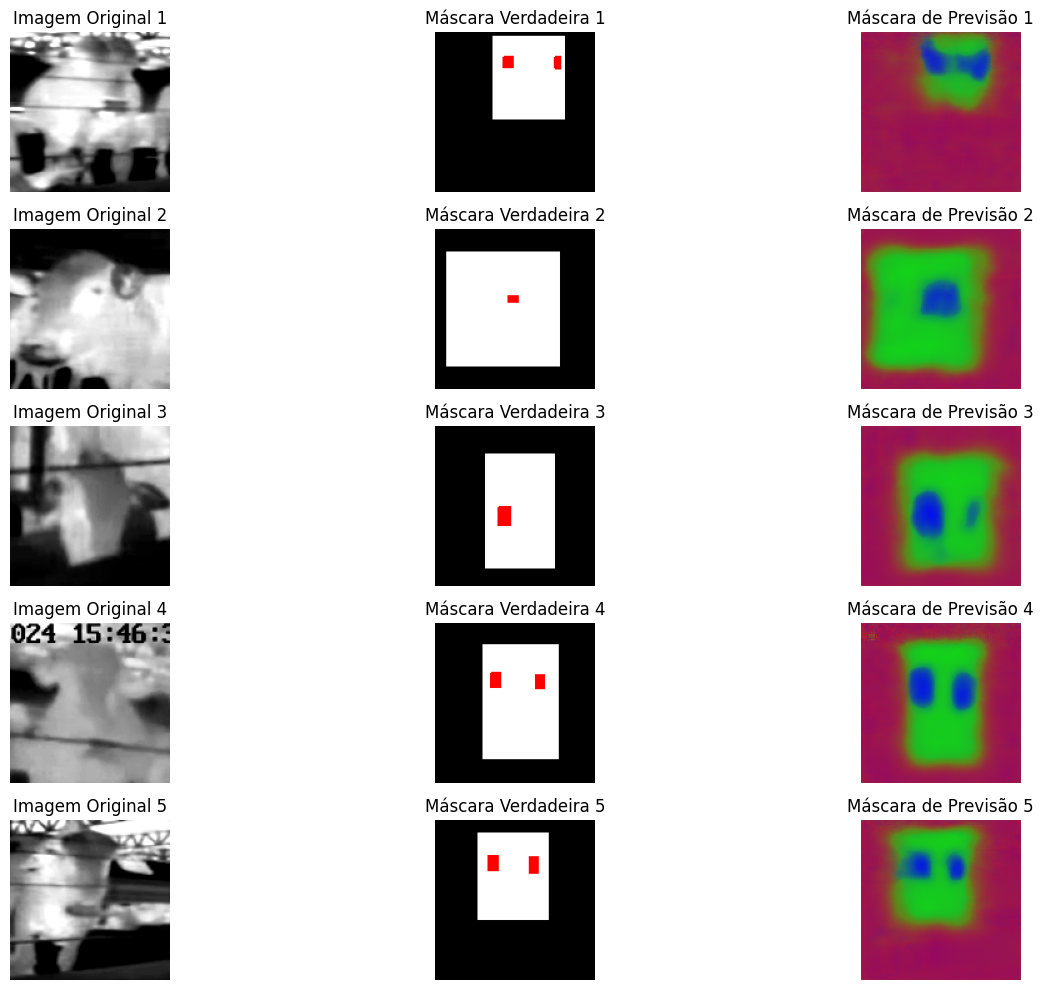

In [ ]:
# 2. Fazer previsões com o X_test
predictions = model.predict(X_test)

# 3. Visualizar algumas previsões
num_images_to_show = 5  # Número de imagens a serem exibidas

plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(num_images_to_show, 3, i * 3 + 1)
    plt.title(f"Imagem Original {i+1}")
    plt.imshow(X_test[i].reshape(X_test.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 2)
    plt.title(f"Máscara Verdadeira {i+1}")
    plt.imshow(y_test[i].reshape(y_test.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 3)
    plt.title(f"Máscara de Previsão {i+1}")
    plt.imshow(predictions[i].reshape(predictions.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Salvar o modelo
model.save('VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5')

from google.colab import files

# Fazer o download do modelo salvo
files.download('VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

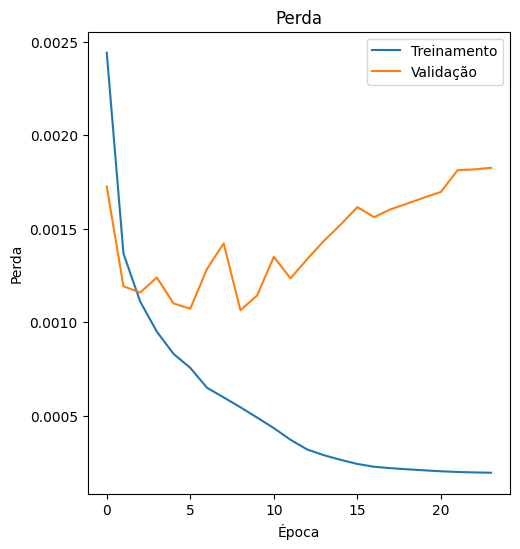

In [ ]:
import matplotlib.pyplot as plt

# Histórias de treinamento e validação
history_dict = history.history

# Gráfico da perda
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


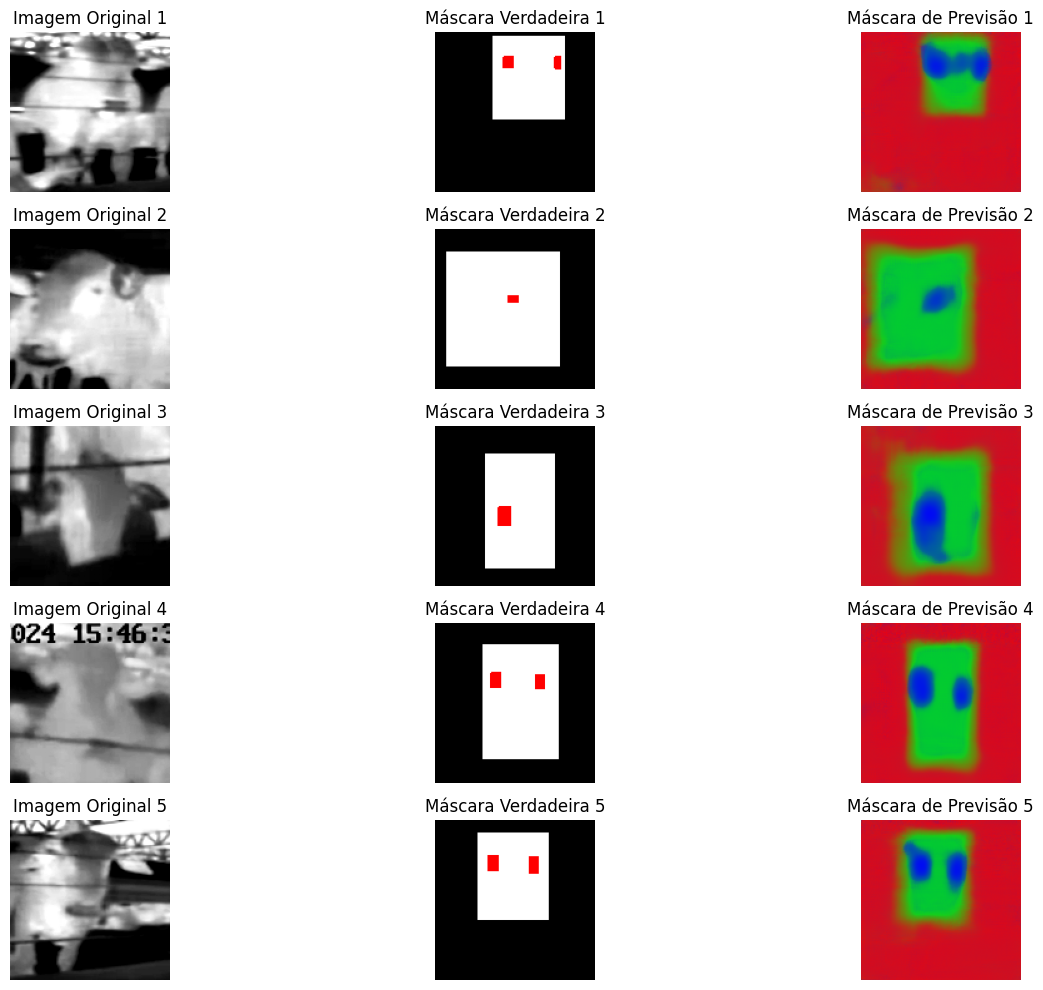

In [ ]:
# 2. Fazer previsões com o X_test
predictions = model.predict(X_test)

# 3. Visualizar algumas previsões
num_images_to_show = 5  # Número de imagens a serem exibidas

plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(num_images_to_show, 3, i * 3 + 1)
    plt.title(f"Imagem Original {i+1}")
    plt.imshow(X_test[i].reshape(X_test.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 2)
    plt.title(f"Máscara Verdadeira {i+1}")
    plt.imshow(y_test[i].reshape(y_test.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 3)
    plt.title(f"Máscara de Previsão {i+1}")
    plt.imshow(predictions[i].reshape(predictions.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

plt.tight_layout()
plt.show()

KeyError: 'accuracy'

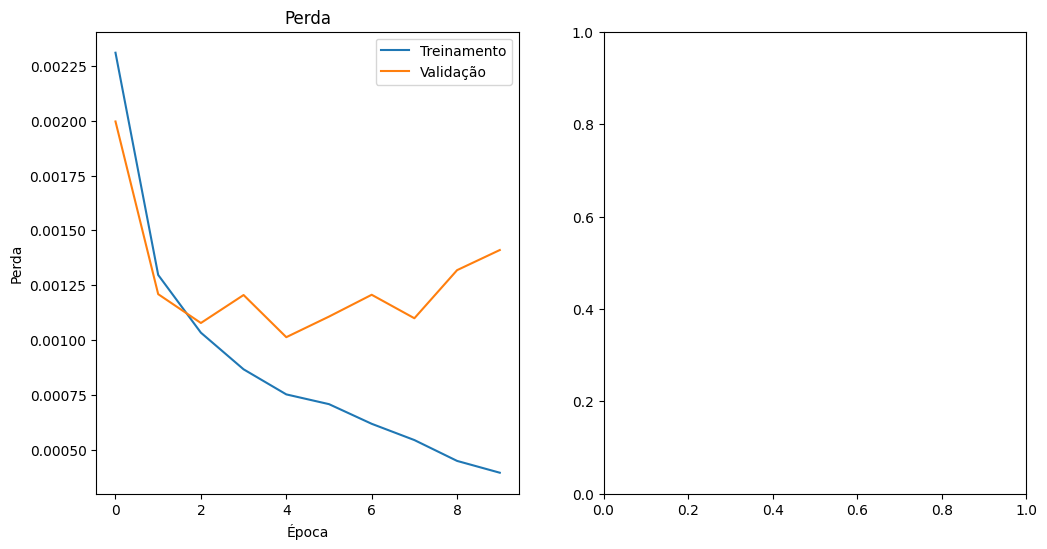

In [ ]:
import matplotlib.pyplot as plt

# Histórias de treinamento e validação
history_dict = history.history

# Gráfico da perda
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


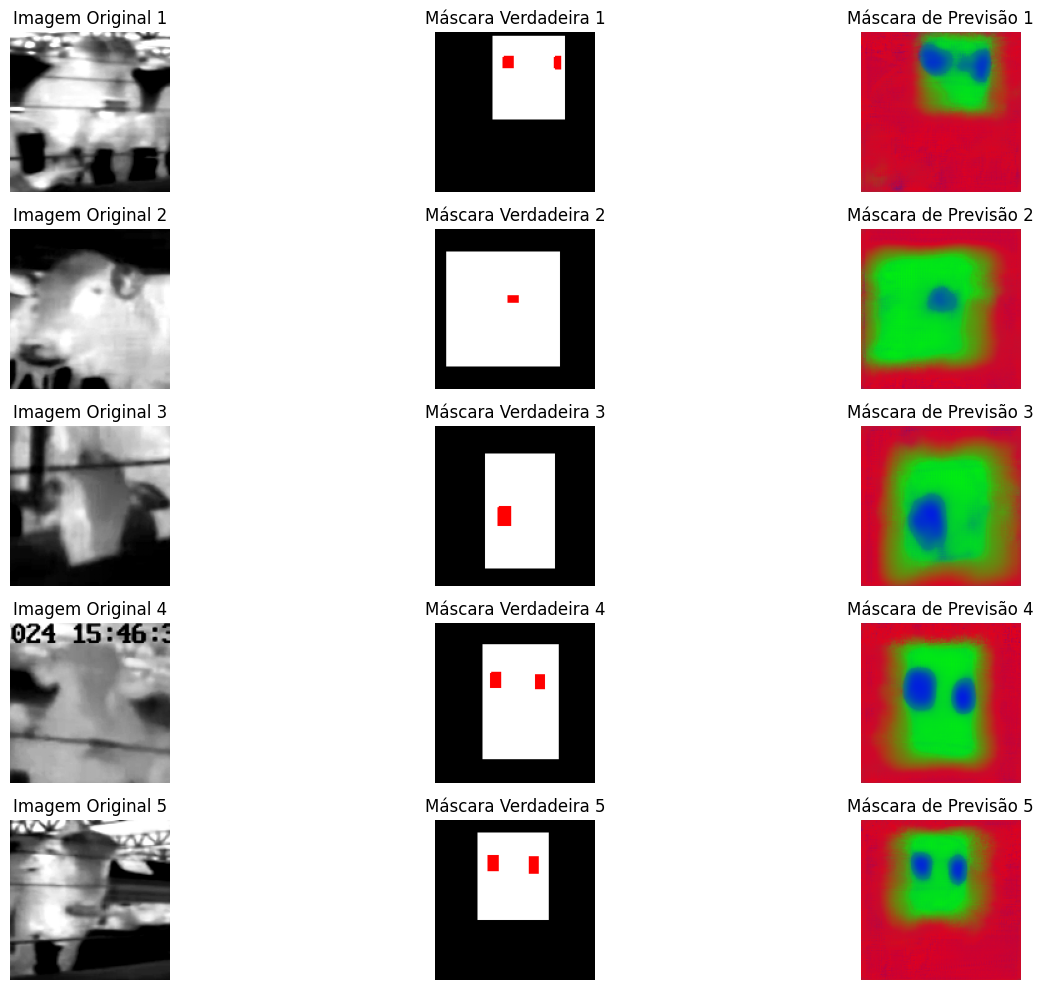

In [ ]:
# 2. Fazer previsões com o X_test
predictions = model.predict(X_test)

# 3. Visualizar algumas previsões
num_images_to_show = 5  # Número de imagens a serem exibidas

plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(num_images_to_show, 3, i * 3 + 1)
    plt.title(f"Imagem Original {i+1}")
    plt.imshow(X_test[i].reshape(X_test.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 2)
    plt.title(f"Máscara Verdadeira {i+1}")
    plt.imshow(y_test[i].reshape(y_test.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 3)
    plt.title(f"Máscara de Previsão {i+1}")
    plt.imshow(predictions[i].reshape(predictions.shape[1:]), cmap='gray')  # Ajuste para o canal se necessário
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Salvar o modelo
model.save('VGG_TransferLearning_V2TOP.h5')

In [ ]:
from google.colab import files

# Fazer o download do modelo salvo
files.download('VGG_TransferLearning_V2TOP.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
val_split = 0.2
val_samples = int(len(X_train) * val_split)
X_train_vgg16, y_train_vgg16 = X_train[:-val_samples], y_train[:-val_samples]
X_val_vgg16, y_val_vgg16 = X_train[-val_samples:], y_train[-val_samples:]

In [ ]:
def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Ajuste para cores se necessário
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalizar se necessário
    img = np.expand_dims(img, axis=-1)  # Adicionar dimensão de canal se necessário
    img = np.expand_dims(img, axis=0)  # Adicionar dimensão de batch
    return img

# 3. Caminho para as imagens de teste e tamanho esperado pelo modelo
test_images_path = 'caminho/para/imagens/de/teste/'
image_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]
target_size = (altura, largura)  # Substitua pelos valores reais do seu modelo

# 4. Fazer previsões e visualizar os resultados
for image_file in image_files:
    image_path = os.path.join(test_images_path, image_file)
    img = preprocess_image(image_path, target_size)

    # Fazer a previsão
    pred = model.predict(img)
    pred_mask = np.squeeze(pred)  # Remove a dimensão do batch

    # Visualizar a imagem original e a máscara de previsão
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_img = cv2.resize(original_img, target_size)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Imagem Original")
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Máscara de Previsão")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.show()

NameError: name 'enhanced_model' is not defined

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('vgg_transfer_learning_best.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = enhanced_model.fit(
    X_train_vgg16, y_train_vgg16,
    validation_data=(X_val_vgg16, y_val_vgg16),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)

enhanced_model.save('vgg_transfer_learning.keras')

Epoch 1/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.3450 - loss: -868.6157 - val_accuracy: 0.1875 - val_loss: -948.5014
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.2988 - loss: -1051.0573 - val_accuracy: 0.1109 - val_loss: -1022.1914
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3418 - loss: -1100.4403 - val_accuracy: 0.1652 - val_loss: -986.7919
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.3051 - loss: -1136.6841 - val_accuracy: 0.2146 - val_loss: -1253.9502
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3031 - loss: -1179.9320 - val_accuracy: 0.2358 - val_loss: 974.5515
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.2886 - loss: -1186.6349 - val_accuracy: 0.7316 - val_loss: -63.8285
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3396 - loss: -1195.1011 - val_accuracy: 0.2455 - val_loss: -1101.7915
Epoch 8/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from google.colab import files

files.download('vgg_transfer_learning_best.keras')

files.download('vgg_transfer_learning.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def cluster_aware_focal_loss(alpha=0.25, gamma=2, spatial_weight=1):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Focal Loss
        focal_loss = -alpha * K.pow(1 - y_pred, gamma) * y_true * K.log(y_pred) - \
                     (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true) * K.log(1 - y_pred)

        # Cluster awareness
        height, width = K.int_shape(y_pred)[1:3]
        y_coords, x_coords = tf.meshgrid(tf.range(height, dtype=tf.float32),
                                         tf.range(width, dtype=tf.float32),
                                         indexing='ij')
        coords = tf.stack([y_coords, x_coords], axis=-1)

        def calculate_centroid(mask):
            total_mass = K.sum(mask, axis=[1, 2]) + epsilon
            weighted_y = K.sum(y_coords[..., tf.newaxis] * mask, axis=[1, 2]) / total_mass
            weighted_x = K.sum(x_coords[..., tf.newaxis] * mask, axis=[1, 2]) / total_mass
            return tf.stack([weighted_y, weighted_x], axis=-1)

        true_centroids = calculate_centroid(y_true)
        pred_centroids = calculate_centroid(y_pred)

        centroid_distance = K.sqrt(K.sum(K.square(true_centroids - pred_centroids), axis=-1))

        # Penalize based on distance from true centroid
        pixel_distances = K.sqrt(K.sum(K.square(coords[..., tf.newaxis, :] - true_centroids[:, tf.newaxis, tf.newaxis, :]), axis=-1))
        distance_penalty = pixel_distances * K.abs(y_true - y_pred)

        total_loss = focal_loss + spatial_weight * distance_penalty

        return K.mean(total_loss)

    return loss

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding='same', use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def vgg16_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # VGG16 as encoder (downsampling path)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Get the output of each block to use in skip connections
    block1_conv2 = vgg16.get_layer('block1_conv2').output
    block2_conv2 = vgg16.get_layer('block2_conv2').output
    block3_conv3 = vgg16.get_layer('block3_conv3').output
    block4_conv3 = vgg16.get_layer('block4_conv3').output

    # Bridge
    bridge = vgg16.get_layer('block5_conv3').output

    # Decoder (Upsampling)
    up6 = UpSampling2D(size=(2, 2))(bridge)
    up6 = concatenate([up6, block4_conv3])
    conv6 = conv_block(up6, 512)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, block3_conv3])
    conv7 = conv_block(up7, 256)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, block2_conv2])
    conv8 = conv_block(up8, 128)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, block1_conv2])
    conv9 = conv_block(up9, 64)

    outputs = Conv2D(3, 1, activation='sigmosofid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model



def vgg16_unet_transfer(input_size=(128, 128, 3), vgg16_model=None):
    if vgg16_model is None:
        raise ValueError("Pre-loaded VGG16 model must be provided")

    inputs = Input(input_size)

    # Use the pre-loaded VGG16 model
    # Assuming the model is already set up for feature extraction (no top layers)

    # Get the output of each block to use in skip connections
    block1_conv2 = vgg16_model.get_layer('block1_conv2').output
    block2_conv2 = vgg16_model.get_layer('block2_conv2').output
    block3_conv3 = vgg16_model.get_layer('block3_conv3').output
    block4_conv3 = vgg16_model.get_layer('block4_conv3').output

    # Bridge
    bridge = vgg16_model.get_layer('block5_conv3').output

    # Decoder (Upsampling)
    up6 = UpSampling2D(size=(2, 2))(bridge)
    up6 = concatenate([up6, block4_conv3])
    conv6 = conv_block(up6, 512)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, block3_conv3])
    conv7 = conv_block(up7, 256)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, block2_conv2])
    conv8 = conv_block(up8, 128)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, block1_conv2])
    conv9 = conv_block(up9, 64)

    outputs = Conv2D(3, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model




# Create and compile the model
model = vgg16_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=cluster_aware_focal_loss(),
              metrics=['accuracy'])

model.summary()

# Verify data shapes
print("X_train_final shape:", X_train_augmented.shape)
print("y_train_final shape:", y_train_augmented.shape)

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-7, mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
        tf.keras.callbacks.ModelCheckpoint('unet_boi_olhos_vgg16.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    ]
)

model.save('unet_boi_olhos_vgg16.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

In [ ]:
X_train_final.shape, y_train_final.shape

((27482, 128, 128, 3), (27482, 128, 128, 3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Definindo as funções personalizadas
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.mean_squared_error(y_true, y_pred)

# Definindo a função de perda personalizada 'loss'
def loss(y_true, y_pred):
    return combined_loss(y_true, y_pred)

# Carregar o modelo treinado
model = load_model('unet_boi_olhos_vgg16.h5', custom_objects={
    'dice_coefficient': dice_coefficient,
    'dice_loss': dice_loss,
    'combined_loss': combined_loss,
    'loss': loss  # Adicionando a função de perda personalizada
})

# Assumindo que X_test e y_test são seus dados de teste
# Fazer previsões
y_pred = model.predict(X_test_transformed)

16/16 [==============================] - 10s 608ms/step


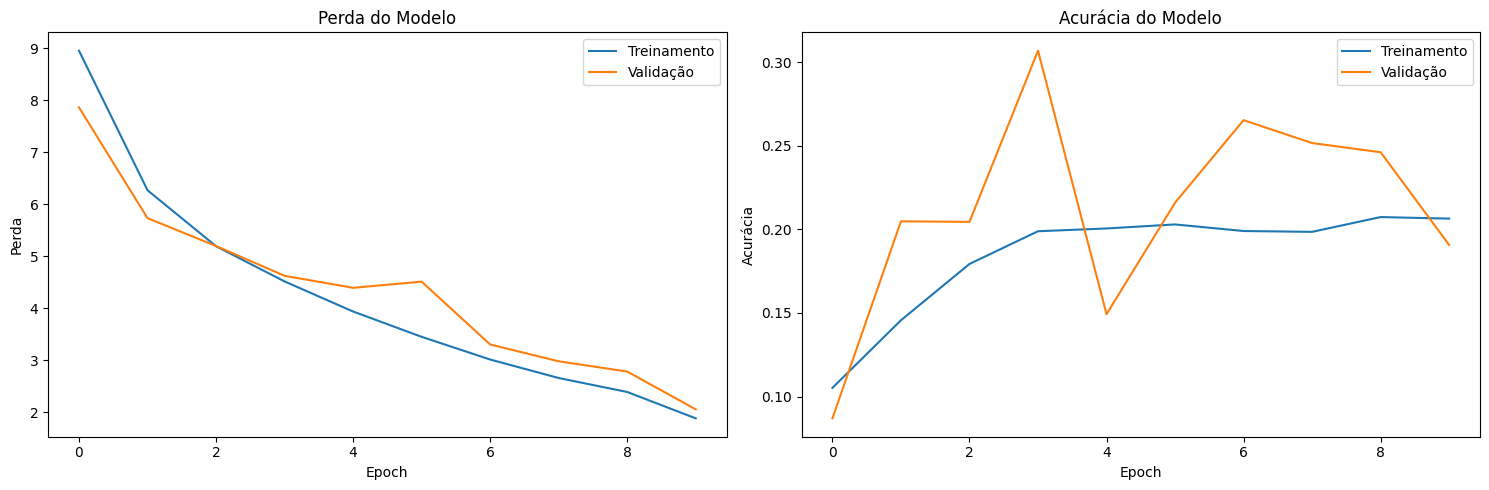

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lista de métricas para plotar
    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de perda
    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    # Plot de acurácia
    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

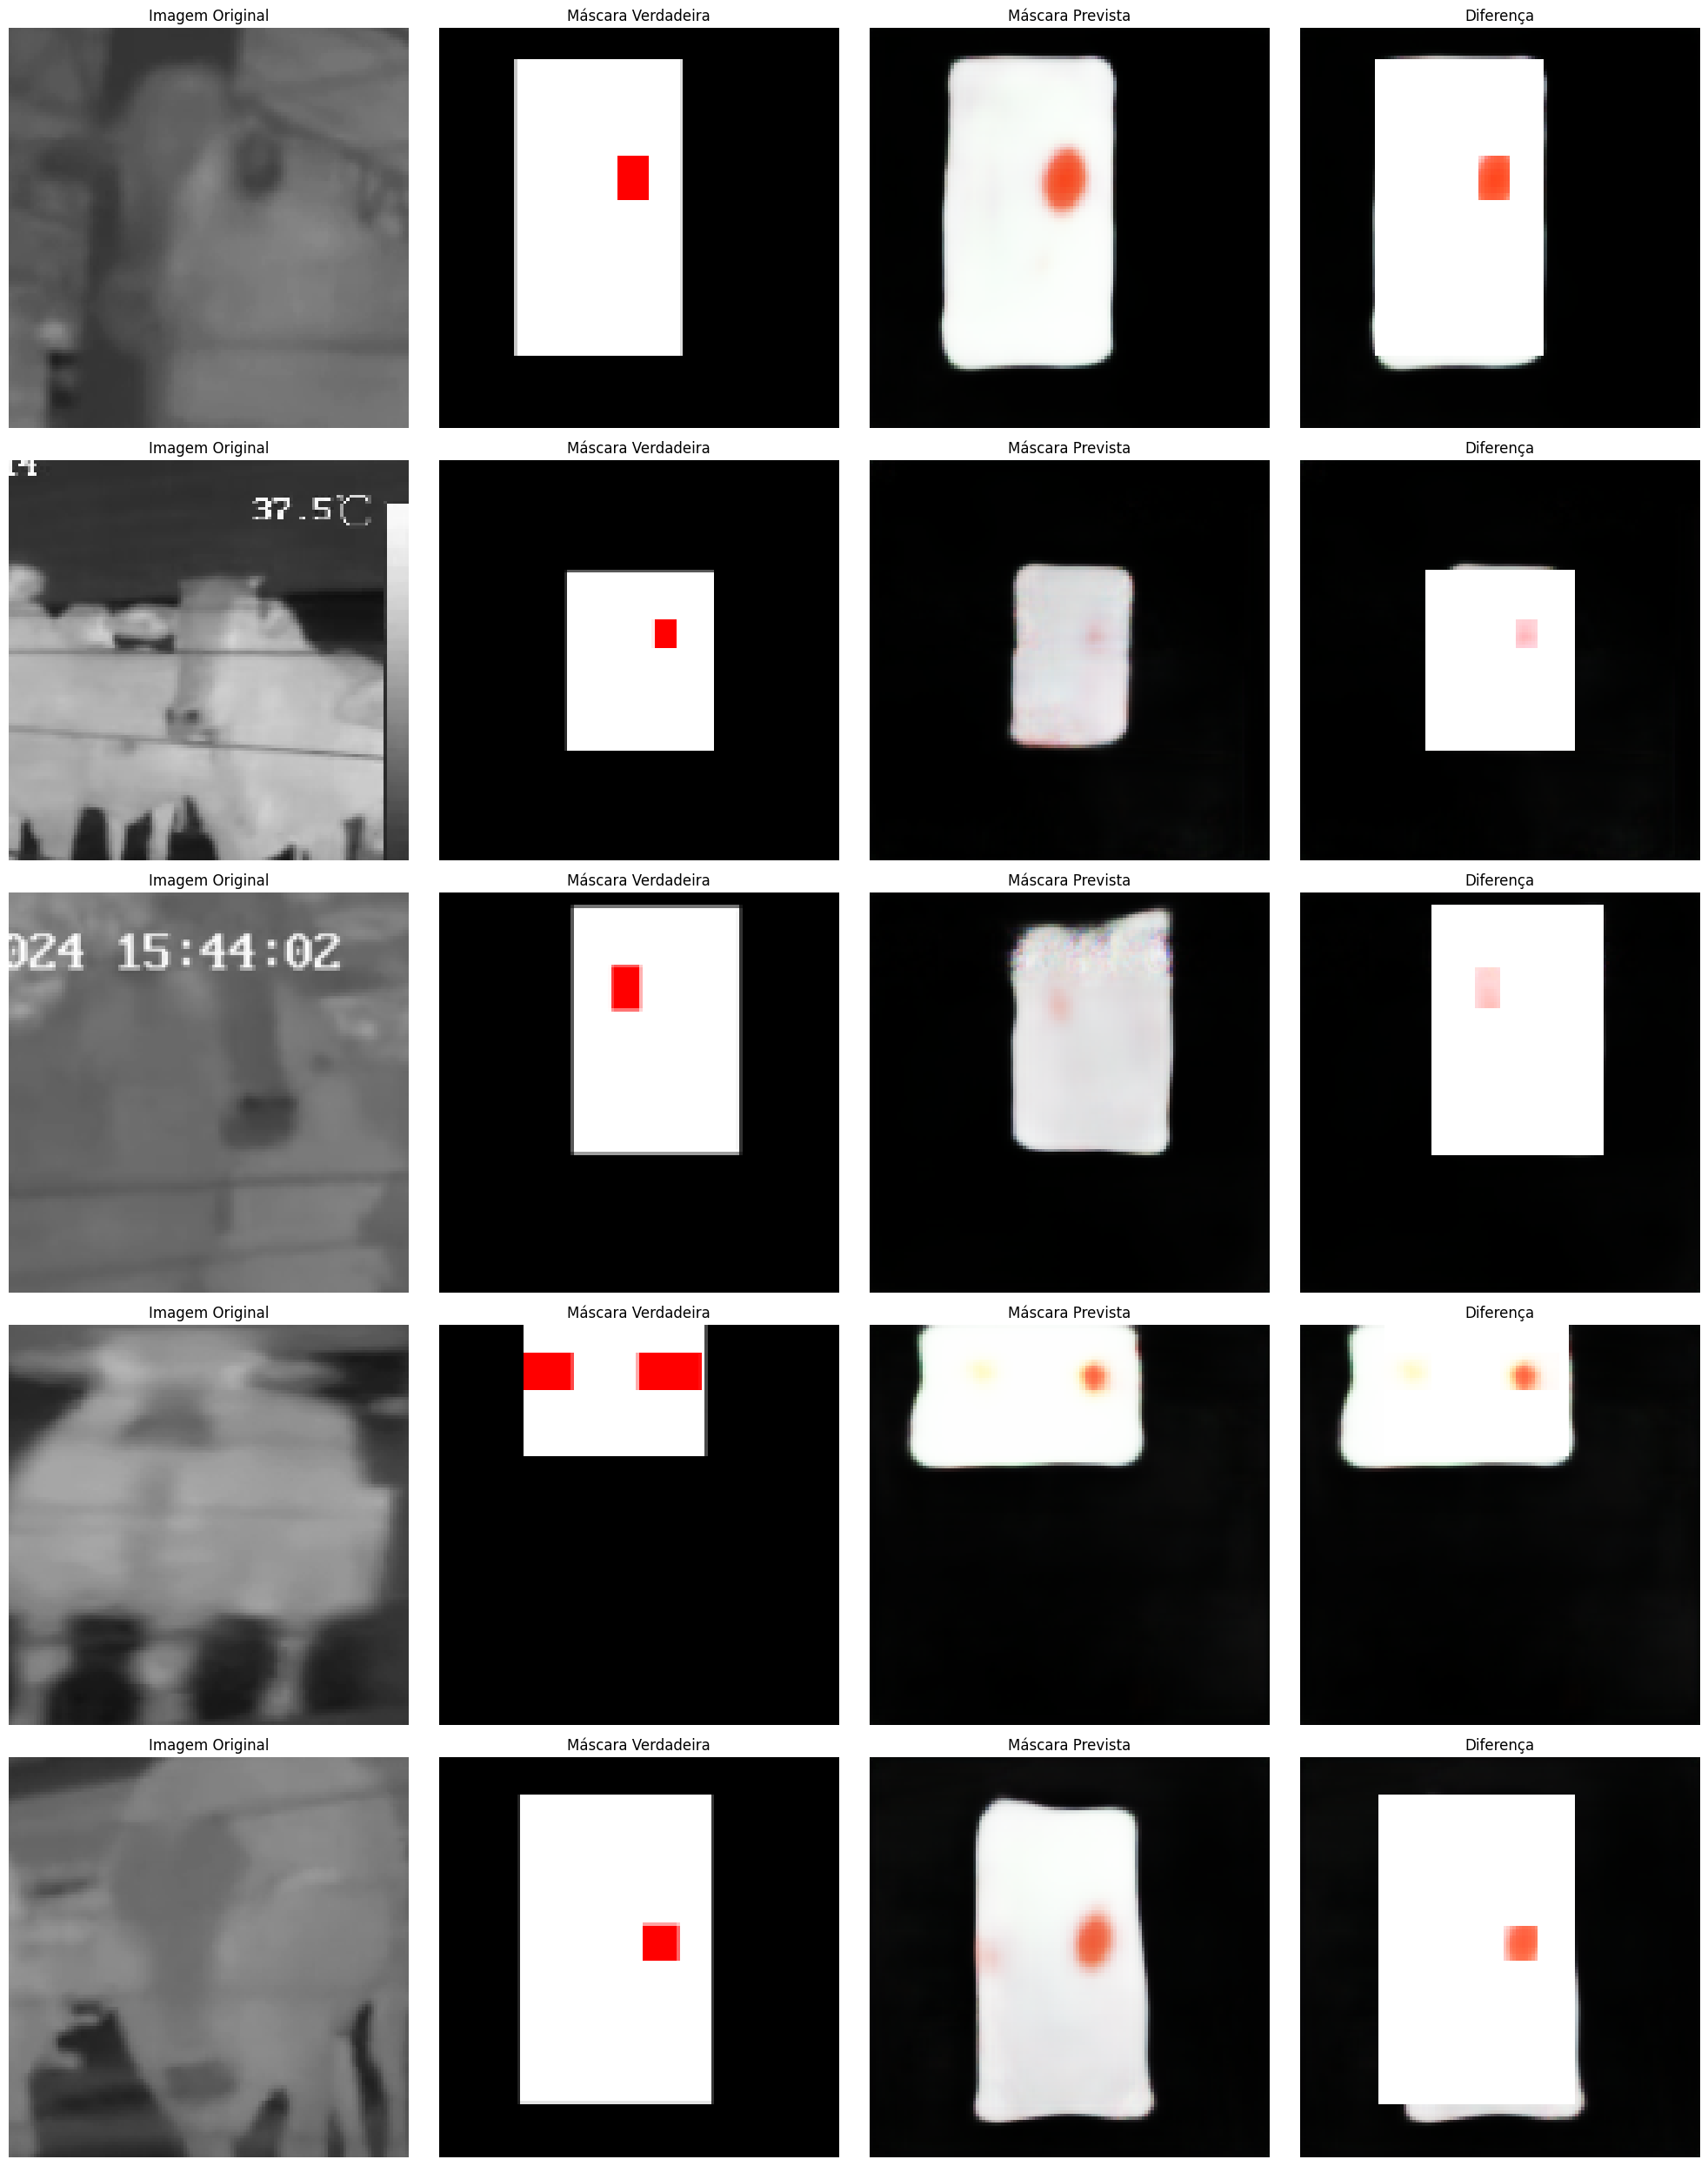

In [ ]:
# Função para visualizar as imagens
def visualize_results(X, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        # Imagem original
        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara verdadeira
        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        # Máscara prevista
        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        # Diferença entre verdadeira e prevista
        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar os resultados
visualize_results(X_test, y_test, y_pred)